In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install GPy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 15.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import GPy
from itertools import combinations
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
features_csv = "/content/drive/MyDrive/Data/EEWS/EEW_features_2024-04-12.csv"
feature_list = [' pkev12 ', ' pkev23 ', ' durP ', ' tauPd ', ' tauPt ',
       ' PDd ', ' PVd ', ' PAd ', ' PDt ', ' PVt ', ' PAt ', ' ddt_PDd ',
               ' ddt_PVd ', ' ddt_PAd ']
label_list = [' PGA ', ' PGV ', ' tPGA ', ' tPGV ']
features_df = pd.read_csv(features_csv)

#train test split
train_features_df, test_features_df = train_test_split(
   features_df, test_size=0.2, random_state=42
)

epsilon = 1e-7
feature_data = np.log10(np.where(np.isnan(features_df[feature_list].values) | (features_df[feature_list].values < 0), 0, features_df[feature_list].values) + epsilon)
label_data = np.log10(np.nan_to_num(features_df[label_list].values, nan=0.0) + epsilon)

In [ ]:
X = feature_data
Y = label_data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, shuffle = False)#random_state=42)

In [ ]:
kernel = GPy.kern.RBF(input_dim=len(feature_list), ARD=True) + GPy.kern.Linear(input_dim=len(feature_list), ARD=True) #+ GPy.kern.White(5)
model = GPy.models.GPRegression(X_train, Y_train, kernel)
# optimize and plot
model.optimize(messages=True)

In [ ]:
# Predict
Y_pred_mean, Y_pred_var = model.predict(X_test)

# Flatten arrays for metric calculations
Y_test_flat = Y_test.ravel()
Y_pred_mean_flat = Y_pred_mean.ravel()

# Calculate metrics
mse = mean_squared_error(Y_test_flat, Y_pred_mean_flat)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_test_flat, Y_pred_mean_flat)
r2 = r2_score(Y_test_flat, Y_pred_mean_flat)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

MSE: 0.10586214156643924
RMSE: 0.3253646286344587
MAE: 0.22440884646929418
R-squared: 0.7254970505693188


In [ ]:
Y_test.shape

(2633, 4)

In [ ]:
Y_pred_mean.shape

(2633, 4)

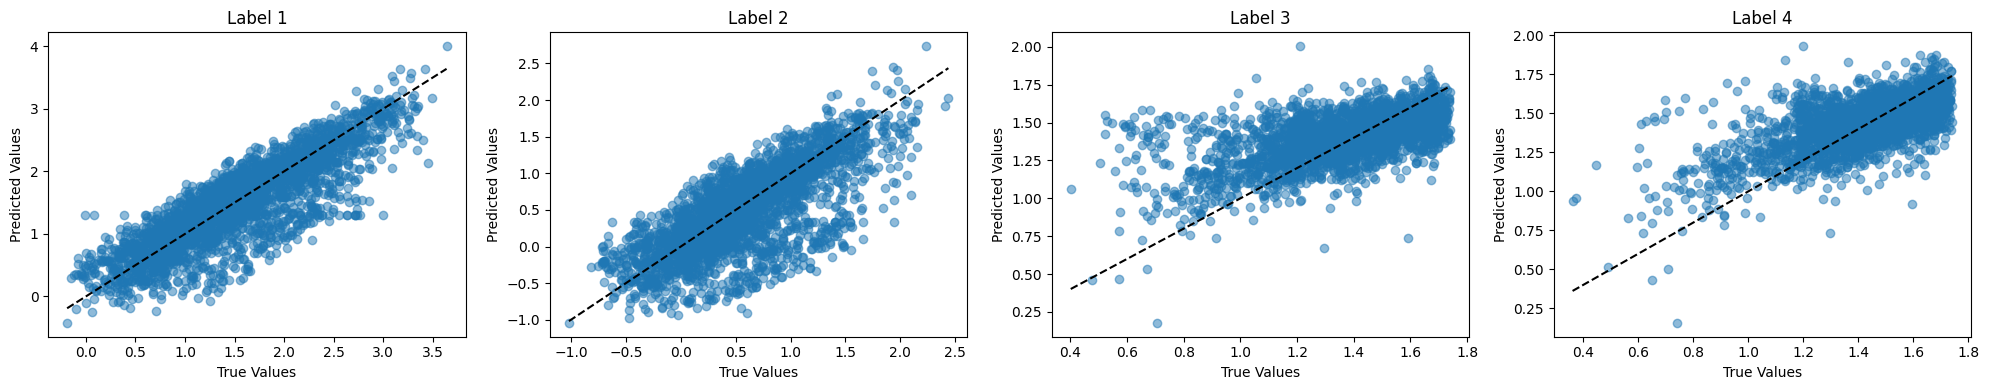

In [ ]:
# Plot
label_no = Y_test.shape[-1]
fig, axes = plt.subplots(nrows=1, ncols=label_no, figsize=(5 * label_no, 4))

for i in range(label_no):
    ax = axes[i] if label_no > 1 else axes
    ax.scatter(Y_test[:, i], Y_pred_mean[:, i], alpha=0.5)  # Scatter plot
    ax.set_title(f'Label {i+1}')
    ax.set_xlabel('True Values')
    ax.set_ylabel('Predicted Values')
    ax.plot([Y_test[:, i].min(), Y_test[:, i].max()], [Y_test[:, i].min(), Y_test[:, i].max()], 'k--')  # Diagonal line

plt.tight_layout()
plt.show()